In [1]:
# Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2

# Import des données

In [2]:
# Import data
df = pd.read_csv('data/adult.csv')

In [3]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
df.info()
# Aucune valeur indiquée comme nulle a priori

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
# les NaN sont sous format '?'
df = pd.read_csv('data/adult.csv', na_values='?')

In [6]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    31978 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [8]:
# Shuffle des lignes, afin d'obtenir un ordre aléatoire
df = df.sample(frac=1, random_state=0)

In [9]:
df['income'].value_counts()
# On remarque que la répartition est inégale : environ 25% du dataset >50K

<=50K    24720
>50K      7841
Name: income, dtype: int64

# Preprocessing

## education & education.num

In [10]:
# On vérifie que une valeur de education.num correspond bien à un unique niveau d'études
df.groupby('education.num').education.nunique()

education.num
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
Name: education, dtype: int64

In [11]:
# On vérifie que les valeurs de education.num traduisent une relation d'ordre dans le niveau d'études
df.groupby('education')['education.num'].mean().sort_values()
# Conclusion : on garde la caractère numérique de education.num car cela traduit une relation d'ordre dans le niveau d'études
# On peut ainsi supprimer la colonne education qui n'est que répétition de education.num

education
Preschool        1
1st-4th          2
5th-6th          3
7th-8th          4
9th              5
10th             6
11th             7
12th             8
HS-grad          9
Some-college    10
Assoc-voc       11
Assoc-acdm      12
Bachelors       13
Masters         14
Prof-school     15
Doctorate       16
Name: education.num, dtype: int64

In [12]:
df = df.drop('education', axis=1)

## fnlwgt

Nombre de valeurs différentes :  21648


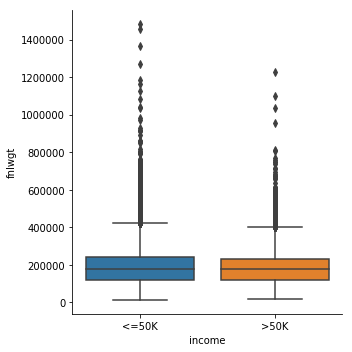

In [13]:
sns.catplot(x="income", y="fnlwgt", kind="box", data=df)
print('Nombre de valeurs différentes : ', df.fnlwgt.nunique())
# Variable non pertinente pour notre problème : même distribution et beaucoup de valeurs distinctes

In [14]:
df = df.drop('fnlwgt', axis=1)

## race

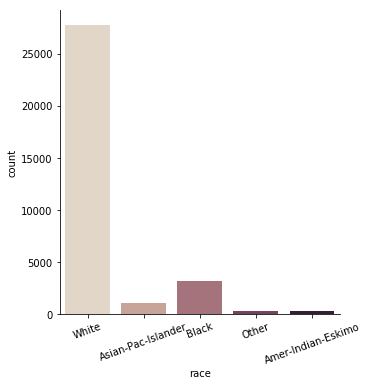

In [15]:
g = sns.catplot(x="race", kind="count",palette="ch:.25", data=df) 
g.set_xticklabels(rotation=20)
g
# La catégorie "White" est très prédominante.

In [16]:
# On regroupe toutes les catégories différentes de "White" sous le libellé "Other"
df['race'] = ['White' if x == 'White' else 'Other' for x in df['race']]

In [17]:
df.groupby('race').race.count()

race
Other     4745
White    27816
Name: race, dtype: int64

# native.country

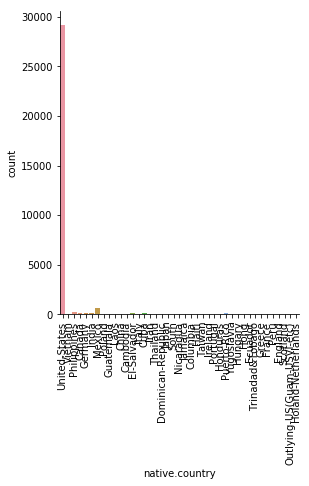

In [18]:
g = sns.catplot(x="native.country", kind="count", data=df)
g.set_xticklabels(rotation=90)
g
# Graphe peu lisible mais on voit clairement que la grosse majorité des personnes ont les USA pour pays d'origine.

In [19]:
# On regroupe toutes les catégories différentes de "United-States" sous le libellé "Other"
# Il faut faire attention aux valeurs manquantes, ne pas les classer dans une catégorie sans le vouloir
country_groups = {} #initialisation du dictionnaire
for country in set(df['native.country']):
    if isinstance(country, str): # si ce n'est pas une valeur nulle
        if country == 'United-States':
            country_groups[country] = 'United-States'
        else:
            country_groups[country] = 'Other'
new_country = []
for x in df['native.country']:
    if not isinstance(x, str): # si c'est une valeur nulle
        new_country.append(x)
    else:
        new_country.append(country_groups[x])
df['native.country'] = new_country

In [20]:
df.groupby('native.country')['native.country'].count()

native.country
Other             2808
United-States    29170
Name: native.country, dtype: int64

## workclass

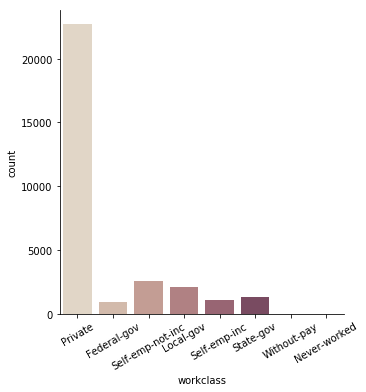

In [21]:
g = sns.catplot(x="workclass", kind="count",palette="ch:.25", data=df) 
g.set_xticklabels(rotation=30)
g
# On constate que la catégorie 'Private' prédomine.
# On remarque 3 types de workclass : le privé ('Private'), le public ('State-gov', 'Federal-gov', 'Local-gov') 
# et les travailleurs indépendants ('Self-emp-not-inc', 'Self-emp-inc', 'Without-pay', 'Never-worked')

In [22]:
# On regroupe les observations selon les 3 groupes définis ci-dessus
# Il faut faire attention aux valeurs manquantes
workclass_groups = {'Private':'Private', 'Self-emp-not-inc':'Independant', 'Self-emp-inc':'Independant', 
                   'Without-pay':'Independant', 'Never-worked':'Independant', 'Federal-gov':'Public',
                   'Local-gov':'Public', 'State-gov':'Public'}
new_workclass = []
for x in df['workclass']:
    if not isinstance(x, str):
        new_workclass.append(x)
    else:
        new_workclass.append(workclass_groups[x])
df['workclass'] = new_workclass

In [23]:
df.groupby('workclass')['workclass'].count()

workclass
Independant     3678
Private        22696
Public          4351
Name: workclass, dtype: int64

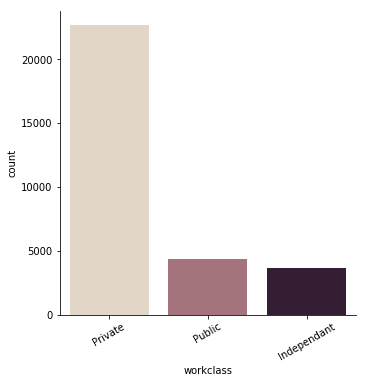

In [24]:
 g = sns.catplot(x="workclass", kind="count",palette="ch:.25", data=df) 
g.set_xticklabels(rotation=30)
g

## marital.status

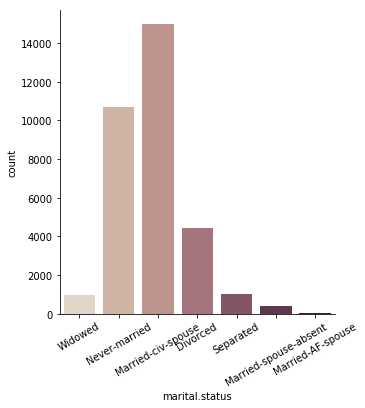

In [25]:
g = sns.catplot(x="marital.status", kind="count",palette="ch:.25", data=df) 
g.set_xticklabels(rotation=30)
g
# On remarque qu'on obtient plusieurs catégories, desquelles ne ressortent pas clairement plusieurs groupes. 
# On va étudier quels regroupements effectuer

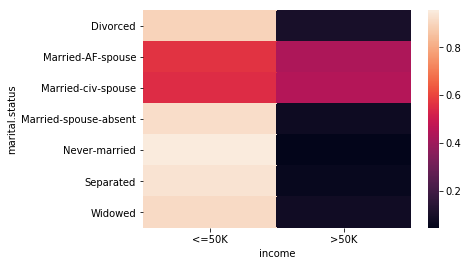

In [26]:
# On cherche à connaître l'influence du status marital sur la variable income
table = (df.groupby(['marital.status', 'income']).income.count()/df.groupby('marital.status').income.count()).unstack()
ax = sns.heatmap(table, yticklabels=table.index, xticklabels=table.columns)
# On observe clairement 2 groupes se dessiner
# On va donc se limiter à 2 status maritaux : 'Married' ou 'Single'

In [27]:
# Pas de valeurs nulles à traiter à part
marital_groups = {'Divorced':'Single', 'Separated':'Single', 'Widowed':'Single', 
                'Married-AF-spouse':'Married', 'Married-civ-spouse':'Married', 'Married-spouse-absent':'Single',
               'Never-married':'Single'}
df['marital.status'] = [marital_groups[x] for x in df['marital.status']]

In [28]:
df.groupby('marital.status')['marital.status'].count()

marital.status
Married    14999
Single     17562
Name: marital.status, dtype: int64

## relationship

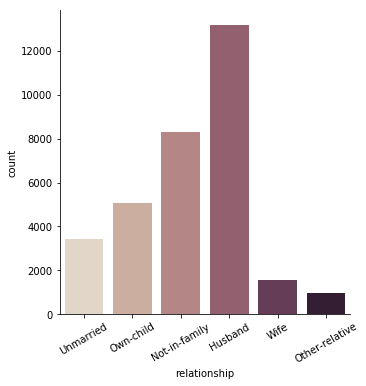

In [29]:
g = sns.catplot(x="relationship", kind="count",palette="ch:.25", data=df) 
g.set_xticklabels(rotation=30)
g
# On remarque qu'on obtient plusieurs catégories, desquelles ne ressortent pas clairement plusieurs groupes. 
# On va étudier quels regroupements effectuer

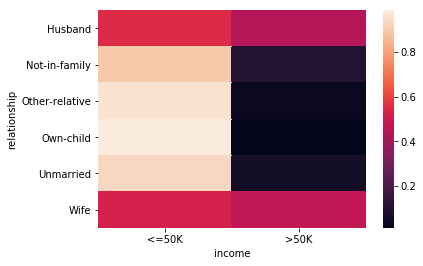

In [30]:
# On cherche à connaître l'influence du status marital sur la variable income
table = (df.groupby(['relationship', 'income']).income.count()/df.groupby('relationship').income.count()).unstack()
ax = sns.heatmap(table, yticklabels=table.index, xticklabels=table.columns)
# On observe clairement 2 groupes se dessiner
# On va donc se limiter à 2 catégories de relationship : 'Couple' ou 'Other'

In [31]:
# Pas de valeurs nulles à traiter à part
relationship_groups = {'Husband':'Couple', 'Wife':'Couple', 'Unmarried':'Other', 
                'Own-child':'Other', 'Other-relative':'Other', 'Not-in-family':'Other'}
df['relationship'] = [relationship_groups[x] for x in df['relationship']]

In [32]:
df.groupby('relationship').relationship.count()

relationship
Couple    14761
Other     17800
Name: relationship, dtype: int64

## Corrélation relationship/marital.status

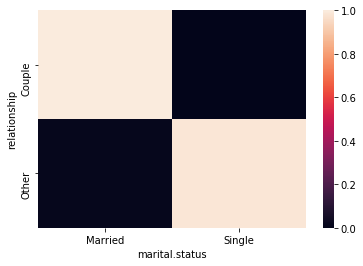

In [33]:
# Les variables 'relationship' et 'marital.status' nous semblent, d'un point de vue logique, assez semblables
# On affiche donc la matrice corrélation entre les deux afin de s'en assurer
table = (df.groupby(['relationship', 'marital.status']).income.count()/df.groupby('relationship').income.count()).unstack()
table = table.fillna(0.0)
ax = sns.heatmap(table, yticklabels=table.index, xticklabels=table.columns)
# Conclusion : les deux variables sont extrêmement corrélées
# On peut donc supprimer 'relationship' sans perdre d'information

In [34]:
df = df.drop('relationship', axis=1)

# Missing data

In [35]:
# On cherche le nombre de valeurs nulles par colonne
total_null = df.isnull().sum().sort_values(ascending=False)
percent_null = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
table_null = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
table_null
# Conclusion : 3 colonnes avec des données manquantes

,Total,Percent
occupation,1843,0.056601
workclass,1836,0.056386
native.country,583,0.017905
income,0,0.000000
hours.per.week,0,0.000000
capital.loss,0,0.000000
capital.gain,0,0.000000
sex,0,0.000000
race,0,0.000000
marital.status,0,0.000000


### workclass

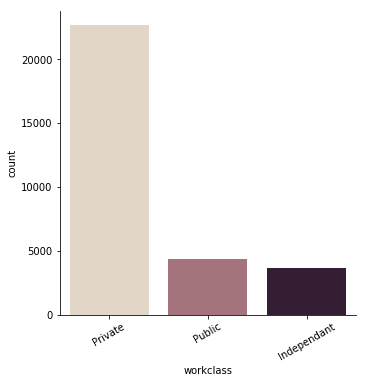

In [36]:
g = sns.catplot(x="workclass", kind="count",palette="ch:.25", data=df) 
g.set_xticklabels(rotation=30)
g
# La classe 'Private' domine très clairement les autres
# On peut donc supposer que les données manquantes sont en réalité des 'Private'

In [37]:
# Imputation valeur workclass
imp_mf = SimpleImputer(missing_values=np.nan, strategy='most_frequent') # On remplace par la valeur la plus fréqeunte
df['workclass'] = imp_mf.fit_transform(df[['workclass']])

In [38]:
# On calcule à nouveau le nombre de valeurs manquantes pour chaque colonne
# On vérifie bien qu'il n'y a plus de valeurs manquantes pour 'workclass'
total_null = df.isnull().sum().sort_values(ascending=False)
percent_null = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
table_null = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
table_null

,Total,Percent
occupation,1843,0.056601
native.country,583,0.017905
income,0,0.000000
hours.per.week,0,0.000000
capital.loss,0,0.000000
capital.gain,0,0.000000
sex,0,0.000000
race,0,0.000000
marital.status,0,0.000000
education.num,0,0.000000


### Native Country

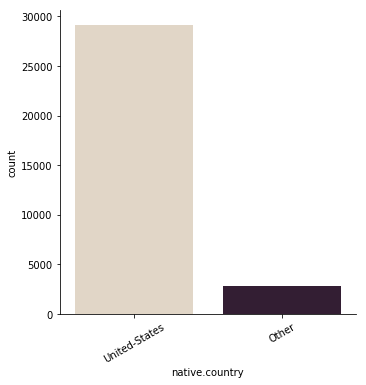

In [39]:
g = sns.catplot(x="native.country", kind="count", palette="ch:.25", data=df)
g.set_xticklabels(rotation=30)
g
# Graphe peu lisible mais on voit clairement que la grosse majorité des personnes ont les USA pour pays d'origine.

In [40]:
# Imputation valeur native.country
df['native.country'] = imp_mf.fit_transform(df[['native.country']])

In [41]:
# On calcule à nouveau le nombre de valeurs manquantes pour chaque colonne
# On vérifie bien qu'il n'y a plus de valeurs manquantes pour 'native.country'
total_null = df.isnull().sum().sort_values(ascending=False)
percent_null = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
table_null = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
table_null

,Total,Percent
occupation,1843,0.056601
income,0,0.000000
native.country,0,0.000000
hours.per.week,0,0.000000
capital.loss,0,0.000000
capital.gain,0,0.000000
sex,0,0.000000
race,0,0.000000
marital.status,0,0.000000
education.num,0,0.000000


### occupation

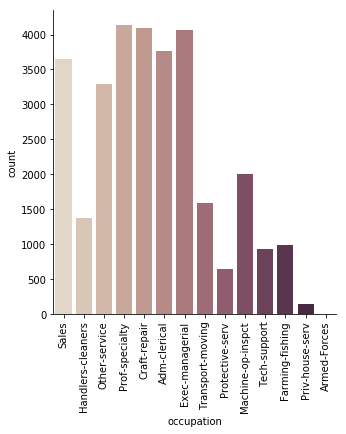

In [42]:
g = sns.catplot(x="occupation", kind="count", palette="ch:.25", data=df)
g.set_xticklabels(rotation=90)
g
# Pas d'occupation qui ressort particulièrement
# Comment choisir quelle occupation imputer ?

In [43]:
# On calcule la distribution initiale des occupations, avant prédiction des valeurs manquantes
total = df.groupby('occupation').occupation.count()
percent = round(df.groupby('occupation').occupation.count()/df.dropna()['occupation'].count(),6)*100
stats_ini = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [44]:
# On prend une copie du dataframe pour pouvoir y appliquer des traitements uniquement pour la prédiciton de 'occupation'
df_knn = df.copy() 

# On ne prend pas les revenus en compte car c'est la variable qu'on veut prédire in fine
df_knn.drop('income', axis=1, inplace=True)

# On va entraîner le modèle KNN sur les observations qui ont une occupation non nulle
df_knn_train = df_knn.dropna()

In [45]:
X_knn_train = pd.get_dummies(df_knn_train.drop('occupation', axis=1))
Y_knn_train = df_knn_train['occupation']

Text(0, 0.5, 'Accuracy')

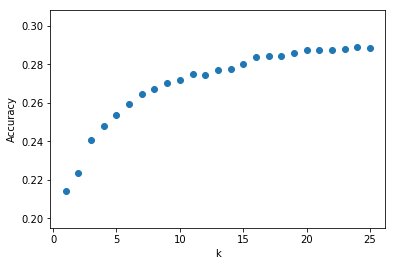

In [46]:
# On calcule l'accuracy du modèle à l'aide de la cross-validation (division du train set en 5 sous-ensembles)
# On challenge la valeur de k en traçant l'accuracy en fonction de k avec k entre 1 et 25
x = range(1,26)
y = [np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=i), X_knn_train, Y_knn_train, scoring='accuracy', cv=5)) for i in x]
plt.scatter(x,y)
plt.xlabel('k')
plt.ylabel('Accuracy')
# On remarque qu'on atteint un palier après k = 20 environ

In [47]:
# Pour k = 20
# Comme il y a 14 catégories, l'accuracy d'un modèle aléatoire serait d'environ 0.07
scores = cross_val_score(KNeighborsClassifier(n_neighbors=20), X_knn_train, Y_knn_train, cv=5, scoring='accuracy')
print('Moyenne accuracy : ', np.mean(scores))
print('Ecart type accuracy : ',np.std(scores))

Moyenne accuracy :  0.2876484992273071
Ecart type accuracy :  0.005295566915071731


In [48]:
# On cherche à faire la prédiction sur les observations ayant une valeur nulle de l'occupation
df_knn_predict = df_knn[df_knn['occupation'].isnull()]
X_knn_predict = pd.get_dummies(df_knn_predict.drop('occupation', axis=1))
# A cause des dummy variables, il faut faire attention au cas où certaines colonnes n'ont pas été créées dans le dataset de prédiction
for column in X_knn_train.columns:
    if column not in X_knn_predict.columns:
        X_knn_predict[column]=0

In [49]:
# On crée le classifieur
clf_knn = KNeighborsClassifier(n_neighbors=20)
# On entraine le classifieur
clf_knn.fit(X_knn_train, Y_knn_train)
# On prédit les valeurs manquantes
Y_knn_predict = clf_knn.predict(X_knn_predict)
# On remplit le dataset des observations à prédire avec les valeurs prédites
df_knn_predict['occupation'] = [x for x in Y_knn_predict]

In [50]:
# On complète les données manquantes du dataframe initial (df) grâce aux données prédites (df_knn_predict)
for index in df_knn_predict.index:
    df.loc[index,'occupation'] = df_knn_predict.loc[index,'occupation']

In [51]:
# On veut valider la pertinence de nos prédictions
# Pour cela, on va tracer la distribution des différentes occupations avant remplissage des valeurs manquantes, puis après
# On a déjà calculé la distirbution initale (stats_ini)
# On calcule maintenant la distribution finale
total = df.groupby('occupation').occupation.count()
percent = round(df.groupby('occupation').occupation.count()/df['occupation'].count(),6)*100
stats_fin = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

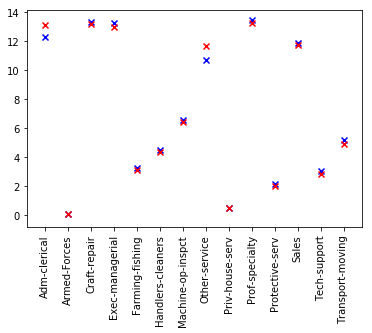

In [52]:
# Graphique de comparaison en pourcentage
fig = plt.figure()
plt.scatter(stats_ini.index, stats_ini['Percent'],color='b', marker='x')  # en bleu : données brutes
plt.scatter(stats_fin.index, stats_fin['Percent'],color='r', marker='x')  # en rouge : données complétées par les prédictions
plt.xticks(rotation=90)
plt.show()
# On constate une répartition quasiment égale à précédemment

In [53]:
# On calcule à nouveau le nombre de valeurs manquantes pour chaque colonne
# On vérifie bien qu'il n'y a plus de valeurs manquantes pour 'occupation'
total_null = df.isnull().sum().sort_values(ascending=False)
percent_null = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
table_null = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
table_null

,Total,Percent
income,0,0.0
native.country,0,0.0
hours.per.week,0,0.0
capital.loss,0,0.0
capital.gain,0,0.0
sex,0,0.0
race,0,0.0
occupation,0,0.0
marital.status,0,0.0
education.num,0,0.0


# Models

In [54]:
# On transforme les variables qui ne prennent que 2 valeurs en variables binaires
# Pour les autres variables qualitatives, on créera des dummy variables
df['native.country'] = [0 if x == 'Other' else 1 for x in df['native.country']]
#df['workclass'] = [0 if x == 'Other' else 1 for x in df['workclass']]
df['sex'] = [0 if x == 'Female' else 1 for x in df['sex']]
df['race'] = [0 if x == 'Other' else 1 for x in df['race']]
df['marital.status'] = [0 if x == 'Single' else 1 for x in df['marital.status']]
df['income'] = [0 if x == '<=50K' else 1 for x in df['income']]

In [55]:
X = df.drop('income', axis=1)
Y = df['income']

In [56]:
X_dummies = pd.get_dummies(X)

## Logistic Regression

In [57]:
clf_lr = LogisticRegression()

In [58]:
# Avec toutes les variables
scores_accuracy = cross_val_score(clf_lr, X_dummies, Y, cv=5, scoring='accuracy')
print ('Accuracy : {0} ; {1}'.format(np.mean(scores_accuracy),np.std(scores_accuracy)))

Accuracy : 0.8489298571633901 ; 0.003889988565944591


1
Accuracy : 0.7995146637362206 ; 0.002896576975411722
2
Accuracy : 0.8115843959406834 ; 0.0035493613803393104
3
Accuracy : 0.8036607516397936 ; 0.003055006996549504
4
Accuracy : 0.8018180893929397 ; 0.0024067979107870244
5
Accuracy : 0.8060564940804463 ; 0.004281987479763468
6
Accuracy : 0.8423268328208448 ; 0.0022509886700796174
7
Accuracy : 0.8435553104714781 ; 0.0026681250379605396
8
Accuracy : 0.8439545120682845 ; 0.00460935901542654
9
Accuracy : 0.8452137211119247 ; 0.003919768881850839
10
Accuracy : 0.8430330937067463 ; 0.003232574188029981
11
Accuracy : 0.8455208086944614 ; 0.00268600230440056
12
Accuracy : 0.8459507605465688 ; 0.002641312355942769
13
Accuracy : 0.8463193533552815 ; 0.0034512907122194944
14
Accuracy : 0.8458893637785854 ; 0.002416200145914258
15
Accuracy : 0.8460736766874491 ; 0.003215925412676211
16
Accuracy : 0.8452751225954819 ; 0.0021127653308012717
17
Accuracy : 0.8476399544513317 ; 0.003195776772410505
18
Accuracy : 0.8473329140245308 ; 0.0040338741220292

Text(0, 0.5, 'Accuracy')

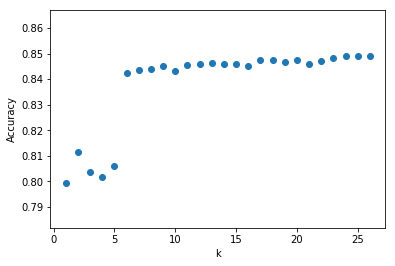

In [59]:
# Avec une méthode de feature selection : SelectKBest
from sklearn.feature_selection import SelectKBest, chi2
x = []
y = []
for i in range(1, len(X_dummies.columns)+1): 
    print(i)
    X_new = SelectKBest(chi2, k=i).fit_transform(X_dummies, Y)
    scores_accuracy = cross_val_score(clf_lr, X_new, Y, cv=5, scoring='accuracy')
    print ('Accuracy : {0} ; {1}'.format(np.mean(scores_accuracy),np.std(scores_accuracy)))
    x.append(i)
    y.append(np.mean(scores_accuracy))
plt.scatter(x,y)
plt.xlabel('k')
plt.ylabel('Accuracy')
    
# Meilleur score pour k=26 avec accuracy = 0.8493

In [60]:
# On veut savoir quelles variables sont ignorées
X_dummies.columns[~SelectKBest(chi2, k=26).fit(X_dummies, Y).get_support()]

Index([], dtype='object')

## Random Forest

In [61]:
clf_rf = RandomForestClassifier()
n_estimators = [i for i in range(100,341,40)]
max_features = ['auto', 'log2', 0.1, 0.5]
parameters = {'n_estimators': n_estimators, 'max_features': max_features}
clf_gs_rf = GridSearchCV(clf_rf, parameters, cv=5, scoring='accuracy')
clf_gs_rf.fit(X_dummies, Y)
clf_gs_rf.cv_results_

{'mean_fit_time': array([ 5.4841156 ,  6.67316608,  8.85650759,  9.69616256, 12.09886956,
        15.24284959, 15.33284621,  4.02721114,  5.92113967,  7.46040974,
        10.7188097 , 11.70371418, 11.30382299, 14.24343429,  3.33180075,
         4.24301643,  5.45332661,  7.24543071,  8.12191119,  9.39391761,
        11.00181146,  7.57121148, 10.25774837, 15.08524289, 16.62695165,
        18.43380928, 21.27800665, 24.09672961]),
 'std_fit_time': array([1.38182548, 0.57506825, 0.92215952, 0.85800542, 0.19871211,
        1.14010132, 0.96838338, 0.44896473, 0.36216073, 0.77966569,
        1.12093536, 0.85445612, 0.50059232, 1.35896964, 0.15741525,
        0.02314417, 0.02863382, 0.12266076, 0.266656  , 0.22385422,
        0.40458071, 0.09229069, 0.2671206 , 0.53082524, 0.68830657,
        0.04967219, 0.12726448, 0.1769589 ]),
 'mean_score_time': array([0.4246274 , 0.57264547, 0.67400646, 0.67163653, 0.83729377,
        1.31768913, 1.02645683, 0.35244026, 0.45264287, 0.65244164,
        0.78

In [62]:
clf_gs_rf.best_params_

{'max_features': 0.5, 'n_estimators': 220}

In [63]:
clf_rf = RandomForestClassifier(n_estimators=300, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_dummies,Y)
# Accuracy
scores = cross_val_score(clf_rf, X_dummies, Y, cv=5, scoring='accuracy')
print("Accuracy du modèle: Moyenne:{}; Ecart-type:{}".format(np.mean(scores),np.std(scores)))

Accuracy du modèle: Moyenne:0.8459200574470035; Ecart-type:0.002883596363670337


In [64]:
# Importance des features
feature_categories = [X_dummies.columns[i].split('_')[0] for i in range(len(X_dummies.columns))]
grouped_features = pd.DataFrame(data={'feature_importance':clf_rf.feature_importances_,'category':feature_categories}).groupby('category').sum()
grouped_features.sort_values(by='feature_importance', ascending=False)

,feature_importance
category,
age,0.212130
marital.status,0.184902
education.num,0.140122
capital.gain,0.132768
hours.per.week,0.109959
occupation,0.091564
capital.loss,0.042779
workclass,0.035819
sex,0.020293


In [65]:
# Sans variable 'sex'
scores_sex = cross_val_score(clf_rf, X_dummies.drop('sex', axis=1), Y, cv=5, scoring='accuracy')
print("Accuracy - Sans variable 'sex' : Moyenne:{}; Ecart-type:{}".format(np.mean(scores_sex),np.std(scores_sex)))

# Sans variable 'race'
scores_race = cross_val_score(clf_rf, X_dummies.drop('race', axis=1), Y, cv=5, scoring='accuracy')
print("Accuracy - Sans variable 'race' : Moyenne:{}; Ecart-type:{}".format(np.mean(scores_race),np.std(scores_race)))

# Sans variable 'native.country'
scores_nc = cross_val_score(clf_rf, X_dummies.drop('native.country', axis=1), Y, cv=5, scoring='accuracy')
print("Accuracy - Sans variable 'native.country' : Moyenne:{}; Ecart-type:{}".format(np.mean(scores_nc),np.std(scores_nc)))

# Sans variable 'race' ni 'native.country'
scores_race_nc = cross_val_score(clf_rf, X_dummies.drop(['race', 'native.country'], axis=1), Y, cv=5, scoring='accuracy')
print("Accuracy - Sans variable 'race' ni 'native.country' : Moyenne:{}; Ecart-type:{}".format(np.mean(scores_race_nc),np.std(scores_race_nc)))


Accuracy - Sans variable 'sex' : Moyenne:0.8452751037331876; Ecart-type:0.003986566387555441
Accuracy - Sans variable 'race' : Moyenne:0.844599437488659; Ecart-type:0.0030070762196176045
Accuracy - Sans variable 'native.country' : Moyenne:0.8453672790499137; Ecart-type:0.004462189659179406
Accuracy - Sans variable 'race' ni 'native.country' : Moyenne:0.8427567752418053; Ecart-type:0.00363327690494197


## XGBoost

In [66]:
# On initialise un modèle XGBoost et on réalise un GridSearch pour déterminer les meilleurs paramètres
clf_xgb = XGBClassifier()
n_estimators = [i for i in range(300,601,50)]
max_depth = [i for i in range(1,4)]
parameters = {'n_estimators': n_estimators, 'max_depth': max_depth}
clf_gs_xgb = GridSearchCV(clf_xgb, parameters, cv=5, scoring='accuracy')
clf_gs_xgb.fit(X_dummies, Y)
clf_gs_xgb.cv_results_

{'mean_fit_time': array([ 9.01092153, 10.69638314, 11.95187864, 13.24312959, 14.54621849,
        16.18752108, 18.74087605, 11.72366571, 12.97708645, 14.04258533,
        16.67154131, 17.27580299, 18.385465  , 20.00958385, 12.40027061,
        14.37941327, 16.51593409, 19.62693005, 21.69644918, 23.31379848,
        24.86213622]),
 'std_fit_time': array([0.58087506, 0.7838911 , 0.55694666, 0.85587888, 0.31633522,
        0.6705868 , 1.40373411, 0.95507974, 0.56335246, 0.85401861,
        0.52540008, 0.64676484, 0.06757819, 0.10814937, 0.07145937,
        0.04557208, 0.1955579 , 0.6766781 , 0.57080435, 0.53677754,
        0.07099556]),
 'mean_score_time': array([0.04918776, 0.05221028, 0.05760894, 0.05760322, 0.06059575,
        0.070192  , 0.07359753, 0.06202955, 0.06840949, 0.06937451,
        0.08478904, 0.08035092, 0.08444042, 0.09174724, 0.07458649,
        0.08338299, 0.09223552, 0.11335068, 0.11760507, 0.12357125,
        0.13143272]),
 'std_score_time': array([0.00636974, 0.00476

In [67]:
# Résultats du GridSearch
clf_gs_xgb.best_params_

{'max_depth': 3, 'n_estimators': 500}

1
Accuracy : 0.8099873584903525 ; 0.001477950923038873
2
Accuracy : 0.831086310652179 ; 0.0023700028821322687
3
Accuracy : 0.8309327621453371 ; 0.0028862158056707616
4
Accuracy : 0.8301956897016778 ; 0.0024460705337424607
5
Accuracy : 0.8386414800336954 ; 0.0039375736920110645
6
Accuracy : 0.8640399931567595 ; 0.004270958874406691
7
Accuracy : 0.8648997978339296 ; 0.004644927655892147
8
Accuracy : 0.8663432301905356 ; 0.0038944398527387463
9
Accuracy : 0.8663432254749621 ; 0.003936762384713393
10
Accuracy : 0.8680017445736009 ; 0.004686365737219792
11
Accuracy : 0.8680017209957331 ; 0.0038860953134133803
12
Accuracy : 0.8680938727345915 ; 0.00425887969678195
13
Accuracy : 0.8684623618006851 ; 0.0040384326148416375
14
Accuracy : 0.8683395729802916 ; 0.004235985281238299
15
Accuracy : 0.868677382524688 ; 0.0039398782896644625
16
Accuracy : 0.8691380704853758 ; 0.0037842918552312707
17
Accuracy : 0.8699980543543419 ; 0.004892533007632402
18
Accuracy : 0.8693224069721076 ; 0.00493681063430

Text(0, 0.5, 'Accuracy')

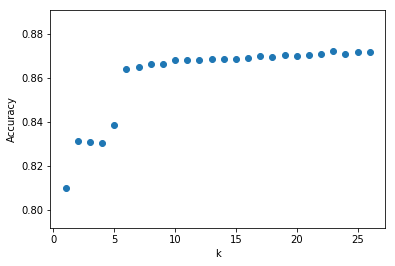

In [68]:
# Avec les paramètres définis par GridSearch, on cherche à sélectionner les features les plus pertinentes
# Pour cela, on utilise SelectKBest et on calcule le score pour toutes les valeurs possibles de k
clf_xgb = XGBClassifier(n_estimators=500, max_depth=3)
x = []
y = []
for i in range(1, len(X_dummies.columns)+1):
    print(i)
    X_new = SelectKBest(chi2, k=i).fit_transform(X_dummies, Y)
    scores_accuracy = cross_val_score(clf_xgb, X_new, Y, cv=5, scoring='accuracy')
    print ('Accuracy : {0} ; {1}'.format(np.mean(scores_accuracy),np.std(scores_accuracy)))
    x.append(i)
    y.append(np.mean(scores_accuracy))
plt.scatter(x,y)
plt.xlabel('k')
plt.ylabel('Accuracy')

# Meilleur score pour k = 24, accuracy de 0.8713

In [69]:
# On veut savoir quelles variables sont ignorées
X_dummies.columns[~SelectKBest(chi2, k=23).fit(X_dummies, Y).get_support()]

Index(['native.country', 'occupation_Armed-Forces', 'occupation_Sales'], dtype='object')